# A Guide for Applying Categorical Encoding Methods

In this notebook, we will be investigating the most common approaches to categorical encoding and how it can integrate into Featuretools software.

## Introduction

When applying machine learning, we most commonly deal with two types of structured data: numeric data (ex: `Age`: [1,2,3]) and categorical data (ex: `color`: ['red', 'blue', 'green']). 

It is often easier to deal with numeric data compared to categorical data because machine learning models typically deal with mathematical vectors--numeric data can thus be used without as many additional complexities. 

However, machine learning algorithms cannot work directly with categorical data and therefore we must do some amount of transformations and engineering on our data before continuing, making categorical encoding an essential part of feature engineering. We will look at some of the most common approaches.

## Categorical Encoding Flowchart

Below is a graphic overview of how to decide which categorical encoding approach to use. Use this flowchart as a rough guide as to how some encoders might perform better in certain situations.

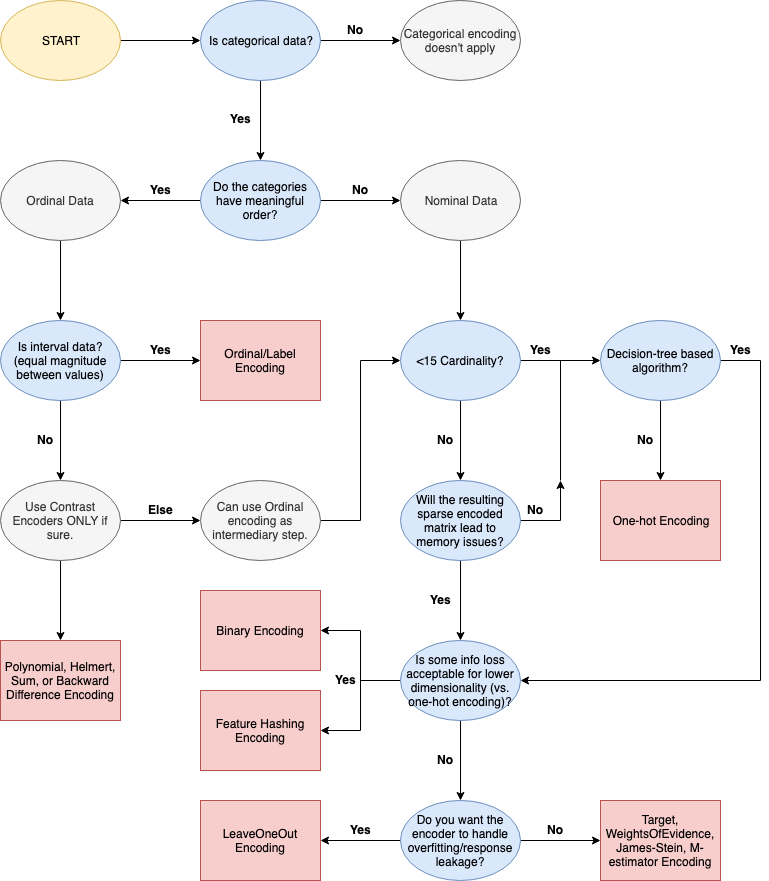

In this notebook, we will be exploring the encoding approaches detailed in this flowchart as well as the [Category Encoders Library](http://contrib.scikit-learn.org/categorical-encoding/index.html), which is maintained by [Will McGinnis](http://www.willmcginnis.com) and based off of [patsy](https://patsy.readthedocs.io/en/latest/API-reference.html).

In [1]:
import pandas as pd
import category_encoders as ce
import patsy.contrasts as pc

In [2]:
pd.options.display.float_format = '{:.2f}'.format #increase readability

## Identify Data

Categorical data is defined as variables that can take one of possible values, specifically on the basis of a qualitative property rather than strictly quantitative. One example of categorical data are the 50 US States--`California` and `Massachusetts` are two distinct values but are not based solely off of numeric attributes.

### Nominal vs. Categorical Data

The categorical encoding approach can vary significantly depending on which of the two major types of categorical variables the data falls under.

#### Nominal Data
First, we have nominal data, which have no meaningful ordering. 

Examples of this include our previously mentioned US States (`California`, `Massachusetts`, `New York`...), music genres (`Classical`, `Hip-hop`, `Jazz`...), or cuisine types (`Chinese`, `Italian`, `Tex-Mex`...).

#### Ordinal Data

On the other hand, we have ordinal data, which do have a meaningful ordering. 

Examples of this include t-shirt sizes (`XS`, `S`, `M`, `L`, `XL`), survey opinions (`strongly dislike`, `dislike`, `like`, `strongly like`), or socieconomic status/income categories (`0-$50000`, `$50000-$100000`, `$100000+`).

## Classic Encoders

These encompass a broad range of encoders that are the most straightfoward and easiest to understand, making them very useful and popular among ML practioners.

### Ordinal/Label Encoding

This is the most straightforward approach to categorical encoding, and is often used as a first step in categorical encoding before applying other encoders.

Ordinal Encoders convert each category value into a whole number. Specifically, the first unique value in the column is assigned to 1, the second unique value becomes 2, and so on.

However, usually keeping the data like this is not recommended, especially if the data is nominal. Machine Learning algorithms will assume this variable is continuous, and thus will either assume an ordering that is either incorrect or does not exist. 

For example, if we assign `California`=1, `Massachusetts`=2, `New York`=3, then the algorithm may assume the ordering `California`<`Massachusetts`<`New York` because it interprets it as $1<2<3$. However, ordering states like that in this context is nonsensical.

In [3]:
df = pd.DataFrame({
    'state':["CA", "MA", "CA", "NY", "CA", "NY"]})
df

,state
0,CA
1,MA
2,CA
3,NY
4,CA
5,NY


After fitting the Ordinal Encoder, it looks like this:

In [4]:
ce_ord = ce.OrdinalEncoder(cols = ['state'])
ce_ord.fit_transform(df)

,state
0,1
1,2
2,1
3,3
4,1
5,3


Even though, as explained earlier, this encoding is unusable for direct application into an ML algorithm, it can still be useful to first convert the column into integers. 

One major reason is that many categorical encoders in third-party libraries require the categorical features to be integers. 

`sklearn`'s `OneHotEncoder` function:

> Encode(s) categorical **integer** features using a one-hot aka one-of-K
> scheme. (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html))

Thus, it is necessary to first use Ordinal Encoding before one is able to use other encoding methods.

However, for **interval data**, an ordinal encoder is useful assuming that one assigns the correct numbers to the correct values. Namely, if we had t-shirt sizes `[S,M,L]`, we'd want them to map to `[1,2,3]`, not `[1,3,2]`. This can be handled according to the encoder.

Otherwise, if the variable is nominal or does not increase evenly, then one should use another encoder before passing in the data to an ML algorithm.

### OneHot/Dummy Encoding

One-hot encoding is by far the most popular approach for categorical encoding due to its ease to use/understand, versatility, and accuracy. 

One-hot encoding works by creating a new column for each value. For each new column, a 1 is assigned if the row contains that column's value and a 0 otherwise.

For example:

In [5]:
ce_one_hot = ce.OneHotEncoder(cols = ['state'])
ce_one_hot.fit_transform(df)

,state_1,state_2,state_3
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,0,1


Note that rows 0, 2, 4, which correspond to `CA`, all have rows `[1,0,0]`. `MA` corresponds to `[0,1,0]` and `NY` correponds to `[0,0,1]`.

One-hot encoding typically performs very well, and Featuretools' `encode_features` currently utilizes this. There is one major drawback, however.

The number of new features generated is equal to the number of unique values, which leads to severe memory issues with high cardinality datasets. Furthermore, one-hot encoded data can [degrade the performance of decision-tree based algorithms](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/).

For an example of how high cardinality can affect performance, imagine if we had a dataset containing all 50 states rather than just 3 in our example. Then, we could go from originally one column to fifty columns, increasing the dimensionality of our matrix greatly.

With even higher cardinality and large datasets, memory can become a serious concern, especially as one-hot encoding leads to extremely sparse matrices (as they are filled mostly with 0's). This leads to our next series of approaches.

### Binary Encoding

In Binary Encoding, the categories' values, if not already in numeric form, are Ordinal Encoded. The resulting integers are converted to binary, and then the digits are split into columns. For example, `5` would become three columns `[1,0,1]`.

In [6]:
ce_bin = ce.BinaryEncoder(cols = ['state'])
ce_bin.fit_transform(df)

,state_0,state_1,state_2
0,0,0,1
1,0,1,0
2,0,0,1
3,0,1,1
4,0,0,1
5,0,1,1


This creates fewer columns than one-hot, and thus is more memory efficient and can reduce dimensionality problems.

Furthermore, similar values may overlap with each other across multiple columns, allowing for machine learning algorithms to learn similarities. 

However, on the other hand, binary encoding can thus imply similiarities where it may not exist, so it really only excels for ordinal data with high cardinality. 

It is typically worth a shot to try binary encoding if one-hot encoding fails. However, for nominal data, typically another approach such as **Hashing** (which gives more control) would make more sense.

### Hashing Encoding

Hashing Encoders employ the [hashing trick](https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f), which you can also read more about [here](https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087).

Essentially, it is similar to one-hot encoding, except it uses a hashing algorithm to map values. For high cardinality datasets, it creates fewer new dimensions but comes at the cost of some information loss due to collisions. However, these collisions do not typically cause problems unless there's a lot of overlap.

When dealing with high cardinality, it is worth trying because it gives you more control than a binary encoder.

In [7]:
ce_hash = ce.HashingEncoder(cols = ['state'], n_components=8)
ce_hash.fit_transform(df)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0


The `n_components` is 8 by default, but can be changed to be less than `k` (number of unique values/number of columns created by one-hot encoding).

The specific hashing algorithm can be changed (default is _md5_), giving the user more control as well as possibly grouping similar categories together within the same/similar hash value.

## Bayesian Encoders

Sometimes one does not want the info loss that comes with Hashing or Binary encoding, but one-hot encoding will not work because of high cardinality. This is when Bayesian Encoders could be extremely useful.

Bayesian Encoders use information from the dependent variable in their encodings. It outputs only one column, and thus works well with high cardinality data. 

For example, we will take our previous example with states and change up the problem. Imagine that each row now corresponds to an individual with two attributes: the state that they're from and the number of cars they own.

In [8]:
df = pd.DataFrame({
    'state':["CA", "MA", "CA", "NY", "CA", "NY"],
    'cars':[3,1,2,0,4,1]})
df

,state,cars
0,CA,3
1,MA,1
2,CA,2
3,NY,0
4,CA,4
5,NY,1


### Target Encoding

Arguably the most straightforward of the Bayesian Encoders, Target Encoding uses the mean of the dependent variable but one must take steps to avoid overfitting/response leakage. 

In [9]:
ce_targ = ce.TargetEncoder(cols = ['state'])
ce_targ.fit_transform(df['state'], df['cars'])

,state
0,2.86
1,1.83
2,2.86
3,0.86
4,2.86
5,0.86


In this example, the state column has now been replaced by a value calculated from the mean of the cars column pertaining to that particular category.

`Category Encoder`'s `TargetEncoder` [function](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html):

>Target encoding for categorical features.

>For the case of categorical target: features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.

>For the case of continuous target: features are replaced with a blend of the expected value of the target given particular categorical value and the expected value of the target over all the training data.

Specifically, note how `CA` has been replaced by `2.86`.

You can experiment with different TargetEncoders/your own version to see what the best fit for your model is.

However, we can see how issues with overfitting and label leakage could quickly arise. If we now wished to predict the number of cars someone owned based on what state they lived in (in addition to other factors), our state column would then leak information.

Similarly, if we were trying to predict someone's income from the state they lived in, the number of cars they owned, and other factors, there's a high chance that we would overfit to the number of cars they owned.

Thus, the need arises for a similar encoder that can take care of these issues.

### LeaveOneOut Encoding

This is very similar to LeaveOneOut, except the row in question leaves its own value out when calculating the mean to avoid contamination.

This is used by Owen Zhang a lot in Kaggle competitions, and he swears by it. You can read more about his take on it and more [here](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions).

In general, just like all Bayesian encoders, it can help split up larger categories logically and fit/group certain categories together better.

However, its main advantage over other encoders is that it takes care of the overfitting and label leakage problem. Although, it is less straightforward compared to other encoders, which may present additional difficulties during the machine learning model process.

In [10]:
ce_leave = ce.LeaveOneOutEncoder(cols = ['state'])
ce_leave.fit_transform(df['state'], df['cars'])

,state
0,3.00
1,1.83
2,3.50
3,1.00
4,2.50
5,0.00


Notice how each row has a different value. This reduces label leakage, and with a more substantial number of rows, should not vary greatly from category to category.

One thing that one must keep in mind is that train/test data must be split before applying the encoder. Otherwise, you will leak information from your test data into your training data. This requires more care when encoding compared to something like a OneHotEncoder.

### Alternative Bayesian Encoders

In certain situations, other encoders may work better. However, these encoders are not as commonly used for Kaggle competitions and real-life applications, but it may help to check these encoders if you want to/have the time.

We will briefly go over each of the encoders.

#### [Weights of Evidence](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)

WoE tells the predictive power of an independent variable in relation to the dependent variable. Namely, it's calculated through: $$\text{WOE} = \ln{\frac{\text{Distribution of non-events}}{\text{Distribution of events}}}.$$

More specifically, it is a way to separate "Goods" from "Bads." As this evolved from the credit scoring world, one example is separating "good customers," ones who do not default on a loan, from "bad customers," who default on a loan. Then, for a particular category, say a specific state such as "California," we take the natural log of the quotient of the percentage of good customers over the percentage of bad customers.

Each category (bin) must be non-zero and contain at least 5% of the total observations.

WOE is especially useful in certain cases, because categories with similar WOE's are typically also similar, which could help with the accuracy of a machine learning algorithm.

In [11]:
df2 = pd.DataFrame({
    'state':["CA", "MA", "CA", "NY", "CA", "NY", "MA"],
    'owns car':[1,1,1,1,0,0,0]})
print(df2)
ce_woe = ce.WOEEncoder(verbose=1, cols = ['state'])
ce_woe.fit_transform(df2['state'], df2['owns car'])

  state  owns car
0    CA         1
1    MA         1
2    CA         1
3    NY         1
4    CA         0
5    NY         0
6    MA         0


,state
0,0.22
1,-0.18
2,0.22
3,-0.18
4,0.22
5,-0.18
6,-0.18


#### [James-Stein](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)

The James-Stein estimator returns a weighted average of the mean target values of the observed feature value and of the overall values.

You can check out the above link to see a more detailed explanation for how the values are calculated. Essentially, it provides a closed-form solution to determining appropriate weights (too much weight on the conditional mean value leads to overfitting and too little leads to underfitting). 

This estimator was only designed for normal distributions and can fail fatally for binary distributions (consider beta model if fatal errors occur).

In [12]:
print(df)
ce_james = ce.JamesSteinEncoder(verbose=1, cols = ['state'])
ce_james.fit_transform(df['state'], df['cars'])

  state  cars
0    CA     3
1    MA     1
2    CA     2
3    NY     0
4    CA     4
5    NY     1


,state
0,3.00
1,1.00
2,3.00
3,0.50
4,3.00
5,0.50


#### [M-estimator](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)

The M-estimator is essentially a simpler version of Target Encoding. M-estimator has only one tunable parameter (m) versus target encoder, which has two tunable parameters (min_samples_leaf and [smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)).

In most cases where m-estimate encoding is applicable, LeaveOneOut Encoding should be considered first.

In [13]:
ce_m = ce.MEstimateEncoder(cols = ['state'])
ce_m.fit_transform(df['state'], df['cars'])

,state
0,0.90
1,0.24
2,0.90
3,0.24
4,0.90
5,0.24


## Contrast Encoders

Contrast Encoders have a number of concerns that some argue make them suboptimal for machine learning. Try them with caution for specific situations, but know that they typically do not work for nominal variables. There are usually better alternatives that are more accurate (one-hot encoding) or have lower dimensions (LeaveOneOut, Hashing).

This [guide](https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/) written by UCLA details Contrast Encoders in R, but does help explain a lot of the underlying calculations. This will need to be considered when deciding if Contrast Encoders should be used.

The general logic is to capture the difference between each category with other categories, and, depending on this difference, separate/order them.

### Helmert Encoding

Compares the mean of the dependent variable for a level to the mean of the dependent variable over all of the previous values. This, in implementation, can be calculated through matrix multiplication.

To illustrate how it works, if we have our 3 states, the first contrast would compare the mean of state 1 (`CA`) with the combined mean of states 2 and 3 (`MA` and `NY`). The second contrast would compare the mean of `MA` with `NY`. 

In practice, it looks like the following:

In [14]:
ce_helmert = ce.HelmertEncoder(cols = ['state'])
ce_helmert.fit_transform(df['state'], df['cars'])
### This output is incorrect. Opened github issue

,intercept,state_0,state_1,state_2,state_3
0,1,-1.00,-1.00,-1.00,-1.00
1,1,1.00,-1.00,-1.00,-1.00
2,1,-1.00,-1.00,-1.00,-1.00
3,1,0.00,2.00,-1.00,-1.00
4,1,-1.00,-1.00,-1.00,-1.00
5,1,0.00,2.00,-1.00,-1.00


### Sum (Deviation) Encoding

Sum Encoding works the same as Helmert encoding except it compares the mean of the dependent variable to the overall mean over all of the levels instead of just the previous values.

In [15]:
ce_sum = ce.SumEncoder(cols = ['state'])
ce_sum.fit_transform(df['state'], df['cars'])
### This output is incorrect. Opened github issue.

,intercept,state_0,state_1
0,1,1.00,0.00
1,1,0.00,1.00
2,1,1.00,0.00
3,1,-1.00,-1.00
4,1,1.00,0.00
5,1,-1.00,-1.00


### Backward Difference

Similar to the previous two except the mean of the dependent variable is compared with the mean of only one level (the prior level).

### Polynomial Difference

Polynomial encoding looks for linear, quadratic, cubic, or any degree trends. This is similar to interval encoding in the sense that categories may follow some sort of regularly increasing pattern, and polynomial encoding can determine that pattern if it fits a polynomial.

This should be reserved for patterns that are uneven but still follow a definite, polynomial pattern.

## Summary

The go-to categorical encoding method should be one-hot encoding in almost every scenario (with the exception of decision-tree based algorithms). It is one of the most straightforward and easy to understand encoders, and also has no drawbacks with regards to machine learning model accuracy. The `encode_features()` function (Featuretools v0.9.0) currently uses one-hot encoding.

However, in the cases with one-hot encoding leads to memory issues, namely datasets with high cardinality, it is necessary to use other encoders.

Ordinal encoding works for a limited number of cases, but is usually the first step before applying other encoders (some libraries can only encode categorical values in an integer format).

Among classic encoders, Binary and Hashing encoders can provide a straightforward and potentially effective way of reducing cardinality while retaining accuracy.

However, the aforementioned two methods can lead to info loss, while Bayesian encoders offer a solution that solves both the cardinality and info loss problems. 

Strive to implement LeaveOneOut Encoding in scenarios where One-Hot encoding does not work, as this method deals with overfitting/response leakage problems that other Bayesian encoders struggle with.

In certain situations, other Bayesian encoders may perform well, but a lot of thought should go into picking a different Bayesian encoder than LeaveOneOut.

Finally, Contrast Encoders provide an interesting way to mathematically separate categories and determine patterns. However, it leads to the same cardinality issues as one-hot encoding and can be a lot more sensitive to errors. Only use Contrast encoding if you're sure, and consider one-hot encoding in such situations instead.

## References/Additional Reading

A compilation of links that I found useful when writing this guide (in addition to the links already in the notebook).

#### Comparative Studies

https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf

http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/

http://www.willmcginnis.com/2016/01/16/even-further-beyond-one-hot-hashing/


#### Useful Reading on Feature Engineering/Categorical Encoding

https://www.datacamp.com/community/tutorials/encoding-methodologies

https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b

https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159

#### Relevant to Target Encoding

https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

https://medium.com/datadriveninvestor/improve-your-classification-models-using-mean-target-encoding-a3d573df31e8

https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2

#### Bayesian Encoding

https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/#HELMERT

#### Machine Learning Application Examples

https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69

#### BaseN Encoding

http://www.willmcginnis.com/2016/12/18/basen-encoding-grid-search-category_encoders/